In [73]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay
import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from kan import KAN

##### Carregando o dataset

In [74]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [75]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

##### Declarando as funções de avaliação do modelo

In [76]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [77]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [78]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [79]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [80]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [81]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [82]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [83]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [84]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [85]:
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int64)

X_val = np.asarray(X_val, dtype=np.float32)
y_val = np.asarray(y_val, dtype=np.int64)

In [86]:
X_train

array([[  0.4,   0.2,   0.2, ...,  10. ,  10. , 100. ],
       [  0.4,   0.2,   0.2, ...,  10. ,  10. , 100. ],
       [  0.6,   0.6,   0.6, ...,  10. ,  10. , 100. ],
       ...,
       [  0.4,   0.8,   0.4, ...,   1. ,  10. ,  10. ],
       [  0.4,   0.4,   0.4, ...,  10. ,  10. , 100. ],
       [  0.4,   0. ,   0.6, ...,   1. ,  10. ,  10. ]], dtype=float32)

In [87]:
y_train

array([0, 0, 1, ..., 0, 1, 0])

##### Transformando os dataframes em tensores

In [88]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)
test_input = torch.tensor(X_val, dtype=torch.float32)
test_label = torch.tensor(y_val, dtype=torch.long)

In [89]:
print(f"{test_input.size()}")
test_input

torch.Size([36726, 22])


tensor([[  0.2000,   0.2000,   0.2000,  ...,  10.0000,  10.0000, 100.0000],
        [  1.0000,   1.0000,   1.0000,  ...,  10.0000,  10.0000, 100.0000],
        [  0.2000,   0.2000,   0.2000,  ...,  10.0000,  10.0000, 100.0000],
        ...,
        [  1.0000,   1.0000,   1.0000,  ...,  10.0000,  10.0000, 100.0000],
        [  0.8000,   0.8000,   0.8000,  ...,  10.0000,  10.0000, 100.0000],
        [  0.2000,   0.8000,   0.2000,  ...,  10.0000,   1.0000,  10.0000]])

In [90]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

##### Criando o modelo da KAN

In [91]:
model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

checkpoint directory created: ./model
saving model version 0.0


In [92]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [93]:
results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 4.61e-01 | test_loss: 4.62e-01 | reg: 1.28e+02 | : 100%|█| 20/20 [08:09<00:00, 24.46s/

saving model version 0.1


##### Visualizando o modelo e resultados

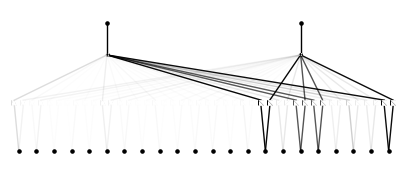

In [94]:
model.plot()

In [95]:
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

Acurácia final no conjunto de treino: 0.9179
Acurácia final no conjunto de teste: 0.9189


In [96]:
test_outputs = model(dataset['test_input'])
test_preds = torch.argmax(test_outputs, dim=1).numpy()
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()

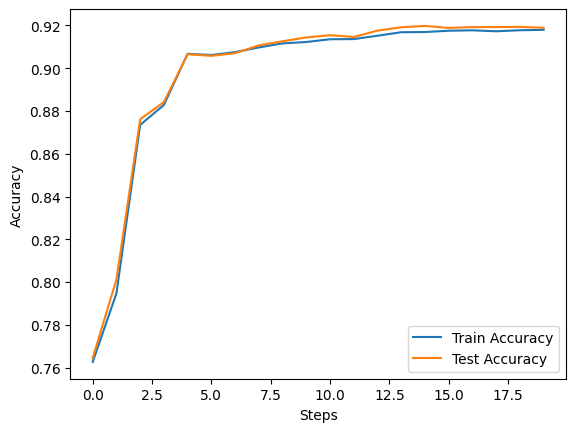

In [97]:
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

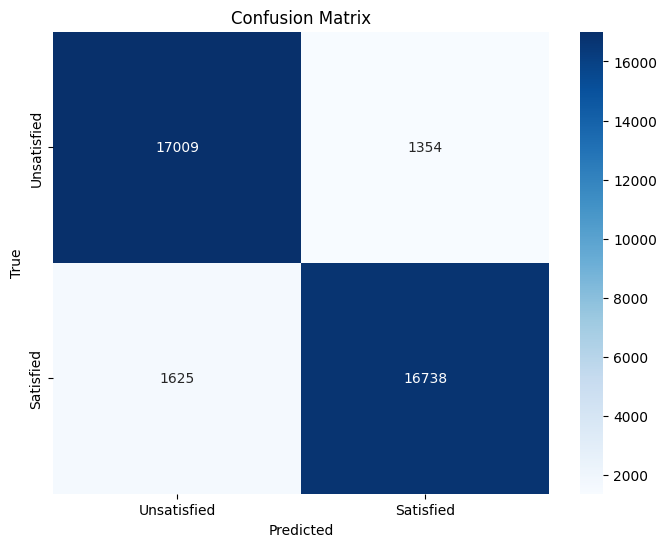

In [98]:
plot_confusion_matrix(test_preds, dataset['test_label'])

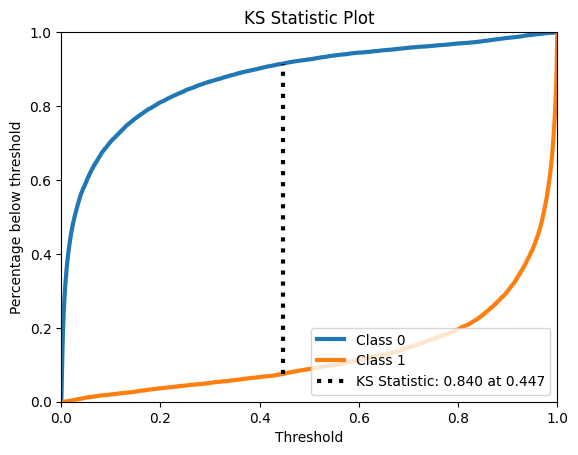

KAN - Test

Accuracy:         0.9189
Recall:           0.9115
Precision:        0.9252
F1:               0.9183
AUROC:            0.9718
AUPR:             0.9716


In [99]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(dataset['test_label'], test_preds, test_probs)
print('KAN - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

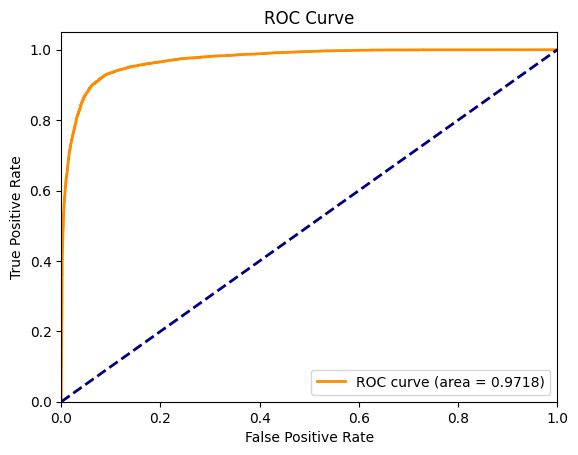

In [100]:
plot_roc_curve(test_probs, dataset['test_label'])